In [1]:
from data import prepare_dataloaders
from models.linear import NLinear, DLinear
from constants import Config
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import lightning as L
import numpy as np
from eval import average_predictions, plot_reconstructed, make_targets

In [37]:
seq_len = 24
pred_len = 96
n_channels = 3

train_loader, val_loader, test_loader = prepare_3d_dataloaders(batch_size=8, seq_len=seq_len, pred_len=pred_len, n_channels=n_channels)

nlinear = NLinear(Config(seq_len=seq_len, pred_len=pred_len, n_channels=n_channels))
nlinear.cuda()


preparing data3d...
done preparing data3d


NLinear(
  (linear): ModuleList(
    (0-2): 3 x Linear(in_features=24, out_features=96, bias=True)
  )
)

In [38]:
tli = iter(train_loader)
for i in range(100):
    batch = next(tli)
x,y = batch
x = x.cuda()
y = y.cuda()
x.shape,y.shape

(torch.Size([8, 24, 3]), torch.Size([8, 96, 3]))

In [12]:
y_hat = nlinear.forward(x)
y_hat.shape

torch.Size([8, 1, 3])

In [13]:
y

tensor([[[  1.0724, 333.4085,  19.7509]],

        [[  1.1286, 338.2799,  20.3234]],

        [[  1.1276, 334.9824,  20.9630]],

        [[  1.1178, 332.3256,  20.4907]],

        [[  1.1132, 327.2790,  19.2461]],

        [[  1.1254, 319.8542,  18.1337]],

        [[  1.0870, 323.3980,  17.5411]],

        [[  1.1297, 324.8519,  17.7253]]], device='cuda:0',
       dtype=torch.float64)

In [14]:
y_hat

tensor([[[  1.2881, 339.2560,  21.0322]],

        [[  1.2657, 338.4501,  20.7917]],

        [[  1.2797, 337.7162,  20.5053]],

        [[  1.2967, 321.5578,  20.2981]],

        [[  1.2974, 326.4244,  20.1478]],

        [[  1.2940, 338.3836,  20.4075]],

        [[  1.2718, 344.6643,  21.0154]],

        [[  1.2846, 347.5431,  21.3955]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)

In [15]:
F.mse_loss(y_hat, y)

tensor(62.6138, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)

In [45]:

nlinear = NLinear(Config(seq_len=seq_len, pred_len=pred_len, n_channels=n_channels))
nlinear.cuda()

losses = []
optimizer = torch.optim.Adam(nlinear.parameters(), lr=1e-4)

for _ in range(20):

    print(len(nlinear.training_step_losses))

    tli = iter(train_loader)
    while True:
        batch = next(tli, None)
        if batch is None:
            break
        optimizer.zero_grad()
        loss = nlinear.training_step(batch, 0)
        loss.backward()
        optimizer.step()

    print(len(nlinear.training_step_losses))
    _losses = [e.item() for e in nlinear.training_step_losses]
    loss = sum(_losses) / len(_losses)
    losses.append(loss)
    nlinear.training_step_losses.clear()

0


c:\Users\nak-o\miniconda3\envs\ds\lib\site-packages\lightning\pytorch\core\module.py:407: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270
0
6270


In [46]:
losses

[296.69031417605913,
 270.22497621021614,
 266.0020441246135,
 263.8768211823139,
 262.55232802795774,
 261.6370972562828,
 260.96129486103877,
 260.4380749649951,
 260.0185610688298,
 259.6731910848716,
 259.38298707801454,
 259.1351408476789,
 258.920641095937,
 258.7329275016804,
 258.5670889212923,
 258.4193638960889,
 258.2868167079619,
 258.1671196771408,
 258.0584022669484,
 257.95914368944756]

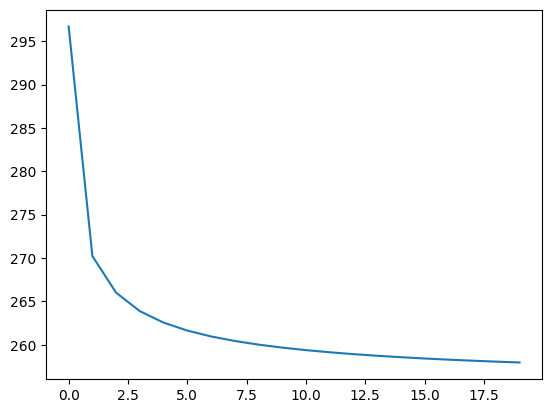

In [47]:
plt.plot(range(len(losses)), losses)

In [31]:
losses = [e.item() for e in nlinear.training_step_losses]

In [32]:
sum(losses)/len(losses)

35.58397290443858

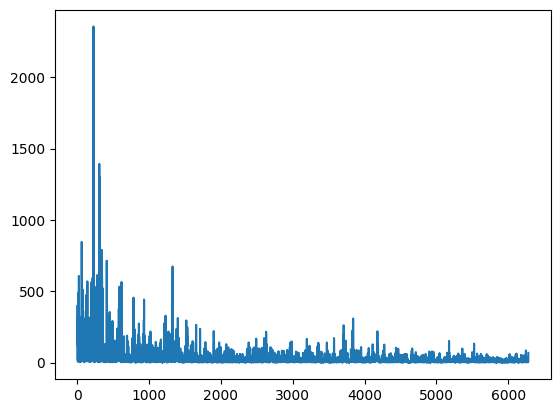

In [33]:
plt.plot(range(len(losses)), losses)

# tensorboard event

In [3]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(
    r'D:\uog\disertation\exp\dlinear\1d\H24-T96\loss_val\events.out.tfevents.1687570726.nack.4576.1'
)

ea.Reload()


In [4]:
ea.Tags()

{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['loss'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

In [5]:
ea.Scalars('loss')

[ScalarEvent(wall_time=1687570726.3233154, step=0, value=1.5767239332199097),
 ScalarEvent(wall_time=1687570729.0126238, step=0, value=1.0992387533187866),
 ScalarEvent(wall_time=1687570731.6101084, step=1, value=0.9458358287811279)]

In [6]:
se = ea.Scalars('loss')[0]
se

ScalarEvent(wall_time=1687570726.3233154, step=0, value=1.5767239332199097)

In [7]:
se.value

1.5767239332199097

# pred

In [2]:
H = 24
T = 96
batch_size = 32
data = '1d'
model = 'nlinear'

checkpoint_path = r"D:\uog\disertation\exp\nlinear\1d\H24-T96\checkpoints\nlinear-epoch=19-val_loss=1.1573.ckpt"

_, _, test_loader, scaler = prepare_dataloaders(
    data, 
    batch_size=batch_size,
    seq_len=H,
    pred_len=T,
    n_channels=3
)

config = Config(seq_len=H, pred_len=T, n_channels=3, lr=1e-3)

model = NLinear(config)
model.load_from_checkpoint(checkpoint_path, config=config)
model.eval()
model.freeze()

trainer = L.Trainer()
predictions = trainer.predict(model, test_loader)

GPU available: True (cuda), used: True


yeah len(test_y) 12571


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nak-o\miniconda3\envs\ds\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 393/393 [00:01<00:00, 197.30it/s]


In [37]:
len(predictions), predictions[0].shape

(393, torch.Size([32, 96, 3]))

In [38]:
batch_x,batch_y = next(iter(test_loader))
batch_x.shape, batch_y.shape

(torch.Size([32, 24, 3]), torch.Size([32, 96, 3]))

In [27]:
batch_y[0]

tensor([[ 0.2208, -0.1139, -0.1907],
        [ 0.5294, -0.0754, -0.3136],
        [ 0.4680, -0.0529, -0.2235],
        [ 0.5509, -0.0281,  0.0154],
        [ 0.3958,  0.0583,  0.1236],
        [ 0.6992,  0.1732,  0.1734],
        [ 0.7203,  0.2128,  0.1650],
        [ 0.0896,  0.3287,  0.2446],
        [ 0.1468,  0.4539,  0.2291],
        [ 0.4342,  0.5731,  0.3647],
        [ 0.4117,  0.6285,  0.5518],
        [ 0.0954,  0.6341,  0.6121],
        [ 0.1515,  0.5921,  0.5491],
        [ 0.2360,  0.5052,  0.3964],
        [ 0.3801,  0.5014,  0.2980],
        [ 0.0521,  0.4686,  0.1733],
        [ 0.3774,  0.3761,  0.1986],
        [ 0.4426,  0.3626,  0.3262],
        [ 0.3902,  0.3748,  0.3641],
        [ 0.9289,  0.4346,  0.3713],
        [ 0.1546,  0.1798,  0.4653],
        [ 0.9293,  0.1073,  0.5845],
        [ 0.4705,  0.2578,  0.5995],
        [ 0.4258,  0.3634,  0.4702],
        [ 0.1812,  0.4456,  0.4117],
        [ 0.5654,  0.4897,  0.3884],
        [-0.0839,  0.5764,  0.3747],
 

In [28]:
batch_y[1]

tensor([[ 0.5294, -0.0754, -0.3136],
        [ 0.4680, -0.0529, -0.2235],
        [ 0.5509, -0.0281,  0.0154],
        [ 0.3958,  0.0583,  0.1236],
        [ 0.6992,  0.1732,  0.1734],
        [ 0.7203,  0.2128,  0.1650],
        [ 0.0896,  0.3287,  0.2446],
        [ 0.1468,  0.4539,  0.2291],
        [ 0.4342,  0.5731,  0.3647],
        [ 0.4117,  0.6285,  0.5518],
        [ 0.0954,  0.6341,  0.6121],
        [ 0.1515,  0.5921,  0.5491],
        [ 0.2360,  0.5052,  0.3964],
        [ 0.3801,  0.5014,  0.2980],
        [ 0.0521,  0.4686,  0.1733],
        [ 0.3774,  0.3761,  0.1986],
        [ 0.4426,  0.3626,  0.3262],
        [ 0.3902,  0.3748,  0.3641],
        [ 0.9289,  0.4346,  0.3713],
        [ 0.1546,  0.1798,  0.4653],
        [ 0.9293,  0.1073,  0.5845],
        [ 0.4705,  0.2578,  0.5995],
        [ 0.4258,  0.3634,  0.4702],
        [ 0.1812,  0.4456,  0.4117],
        [ 0.5654,  0.4897,  0.3884],
        [-0.0839,  0.5764,  0.3747],
        [-0.2310,  0.7213,  0.5189],
 

In [39]:
pred_first_batch = predictions[0]
pred_first_batch.shape

torch.Size([32, 96, 3])

In [40]:
pred_first_batch[0]

tensor([[-1.8889e+00, -6.8398e-02,  1.7830e-02],
        [-1.9044e+00, -7.4398e-02, -1.5600e-01],
        [-7.6185e-01, -2.6844e-01, -1.0408e-01],
        [ 1.4050e-01,  7.8756e-02, -3.7918e-01],
        [-2.1028e+00, -5.5917e-02, -2.9815e-01],
        [-4.2042e-02, -1.7596e-01, -2.7173e-01],
        [-1.5434e+00,  1.5369e-02, -1.5337e-01],
        [-2.7555e-01, -2.7537e-02, -1.0579e-01],
        [-1.6565e+00, -3.9050e-01,  1.6582e-01],
        [-1.2537e+00, -2.1923e-01, -2.1341e-01],
        [-1.5407e+00, -2.2889e-01, -5.0705e-01],
        [-3.4354e-01,  5.9364e-02, -6.1191e-01],
        [-1.7230e+00, -3.1919e-01, -9.2232e-02],
        [-4.1314e-02, -2.0546e-01, -3.7068e-01],
        [-9.1843e-01,  2.2526e-01, -1.6921e-01],
        [ 9.3421e-02,  6.6498e-02, -2.2303e-01],
        [-2.2001e+00, -2.6854e-01, -3.0656e-01],
        [-1.5614e+00, -7.7381e-04,  1.7361e-01],
        [-1.6392e+00, -5.1514e-02, -4.1143e-01],
        [-1.7785e+00, -3.2939e-01, -1.5087e-01],
        [-5.9281e-01

In [41]:
pred_first_batch[1]

tensor([[-1.6155, -0.4306,  0.0653],
        [-1.4519, -0.2329, -0.2099],
        [-0.5603, -0.4749, -0.1335],
        [ 0.0030, -0.3292, -0.2632],
        [-1.4923, -0.4233, -0.1455],
        [ 0.0302, -0.4597, -0.1709],
        [-0.9629, -0.2226, -0.0970],
        [-0.3382, -0.4080, -0.0240],
        [-1.1106, -0.4142,  0.2603],
        [-1.0503, -0.5149, -0.1322],
        [-1.4797, -0.5873, -0.4795],
        [-0.0330, -0.1828, -0.4885],
        [-1.4236, -0.3674, -0.1728],
        [-0.1373, -0.3361, -0.2474],
        [-0.9058, -0.0596, -0.1942],
        [-0.0202, -0.1494, -0.1576],
        [-1.9723, -0.5262, -0.0992],
        [-1.0449, -0.1211,  0.0333],
        [-1.4141, -0.0619, -0.3036],
        [-1.3287, -0.3275, -0.0790],
        [-0.3663, -0.5885, -0.3551],
        [-0.1409, -0.0953, -0.2071],
        [-1.2068, -0.2175, -0.0455],
        [-0.4203, -0.2692, -0.1437],
        [-1.3666, -0.5125,  0.1484],
        [-0.6301, -0.5162, -0.0761],
        [-1.1043, -0.3636, -0.1064],
 

In [4]:
preds = []
for batch_index,batch in enumerate(predictions):
    for pred_sequence_index, pred_sequence in enumerate(batch):
        for time_step_index, time_step in enumerate(pred_sequence):
            pred_index = (batch_index * batch_size) + pred_sequence_index + time_step_index
            if pred_index >= len(preds):
                preds.append([])
            preds[pred_index].append(list(time_step))


len(preds)

12666

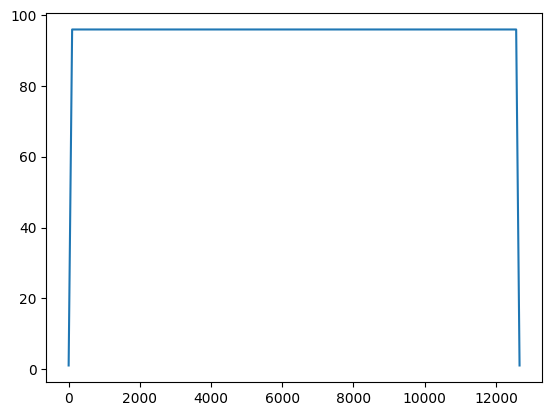

In [5]:
lengths = [len(e) for e in preds]
plt.plot(range(len(lengths)), lengths)

In [53]:
np.mean([
    [1,2],
    [3,4],
    [4,5]
], axis=0)

array([2.66666667, 3.66666667])

In [6]:
avg_preds = []
for pred in preds:
    temp = np.mean(pred, axis=0)
    avg_preds.append(temp)

np.array(avg_preds).shape

(12666, 3)

In [11]:
type(predictions)

list

In [23]:
def average_predictions(predictions: list, batch_size: int, only_first=False) -> np.ndarray:
    preds = []
    for batch_index,batch in enumerate(predictions):
        for pred_sequence_index, pred_sequence in enumerate(batch):
            for time_step_index, time_step in enumerate(pred_sequence):
                pred_index = (batch_index * batch_size) + pred_sequence_index + time_step_index
                if pred_index >= len(preds):
                    preds.append([])
                preds[pred_index].append(list(time_step))

    avg_preds = []
    for pred in preds:
        if only_first:
            temp = np.array(pred)[0,:]
        else:
            temp = np.mean(pred, axis=0)
        avg_preds.append(temp)

    return np.array(avg_preds)


In [31]:
preds = average_predictions(predictions, batch_size)

In [24]:
batch_y_list = []
for batch in test_loader:
    x,y = batch
    batch_y_list.append(y)

targets = average_predictions(batch_y_list, batch_size, only_first=True)
targets.shape

(12666, 3)

In [27]:
batch_y_list[0][0][0][0].item()

0.22081115949850885

In [26]:
targets[0:10]

array([[ 0.22081116, -0.11394513, -0.19073677],
       [ 0.52944306, -0.07540851, -0.3136283 ],
       [ 0.46796191, -0.05294528, -0.2234866 ],
       [ 0.55087822, -0.02807792,  0.01535559],
       [ 0.39581862,  0.05827985,  0.12356465],
       [ 0.69917469,  0.17321589,  0.17335976],
       [ 0.72032333,  0.21283501,  0.1649697 ],
       [ 0.08959113,  0.32867007,  0.24459381],
       [ 0.14677884,  0.45392869,  0.22910027],
       [ 0.43419681,  0.57306907,  0.36472525]])

In [17]:
batch_x,batch_y = next(iter(test_loader))
batch_y[0]

tensor([[ 0.2208, -0.1139, -0.1907],
        [ 0.5294, -0.0754, -0.3136],
        [ 0.4680, -0.0529, -0.2235],
        [ 0.5509, -0.0281,  0.0154],
        [ 0.3958,  0.0583,  0.1236],
        [ 0.6992,  0.1732,  0.1734],
        [ 0.7203,  0.2128,  0.1650],
        [ 0.0896,  0.3287,  0.2446],
        [ 0.1468,  0.4539,  0.2291],
        [ 0.4342,  0.5731,  0.3647],
        [ 0.4117,  0.6285,  0.5518],
        [ 0.0954,  0.6341,  0.6121],
        [ 0.1515,  0.5921,  0.5491],
        [ 0.2360,  0.5052,  0.3964],
        [ 0.3801,  0.5014,  0.2980],
        [ 0.0521,  0.4686,  0.1733],
        [ 0.3774,  0.3761,  0.1986],
        [ 0.4426,  0.3626,  0.3262],
        [ 0.3902,  0.3748,  0.3641],
        [ 0.9289,  0.4346,  0.3713],
        [ 0.1546,  0.1798,  0.4653],
        [ 0.9293,  0.1073,  0.5845],
        [ 0.4705,  0.2578,  0.5995],
        [ 0.4258,  0.3634,  0.4702],
        [ 0.1812,  0.4456,  0.4117],
        [ 0.5654,  0.4897,  0.3884],
        [-0.0839,  0.5764,  0.3747],
 

In [32]:
preds.shape, targets.shape

((12666, 3), (12666, 3))

In [2]:
# load model
H = 168
T = 96
batch_size = 32
data = '1d'
model = 'dlinear'

checkpoint_path = r"D:\uog\disertation\exp\dlinear\1d\H168-T96\checkpoints\dlinear-epoch=19-val_loss=0.6301.ckpt"

_, _, test_loader, scaler = prepare_dataloaders(
    data, 
    batch_size=batch_size,
    seq_len=H,
    pred_len=T,
    n_channels=3
)

config = Config(seq_len=H, pred_len=T, n_channels=3, lr=1e-3)

model = DLinear(config)
model = model.load_from_checkpoint(checkpoint_path, config=config)
model.eval()
model.freeze()

trainer = L.Trainer()
predictions = trainer.predict(model, test_loader)

Predicting DataLoader 0: 100%|██████████| 392/392 [00:02<00:00, 170.19it/s]


In [12]:
x = torch.vstack(predictions)
x.shape

torch.Size([12535, 96, 3])

In [3]:
# pred
means_preds, firsts_preds = average_predictions(predictions)
means_preds = scaler.inverse_transform(means_preds)
firsts_preds = scaler.inverse_transform(firsts_preds)

In [4]:
# targets
targets_means, targets_firsts = make_targets(test_loader)
targets_means = scaler.inverse_transform(targets_means)
targets_firsts = scaler.inverse_transform(targets_firsts)

In [5]:
means_preds.shape, firsts_preds.shape, targets_means.shape, targets_firsts.shape

((12630, 3), (12535, 3), (12630, 3), (12535, 3))

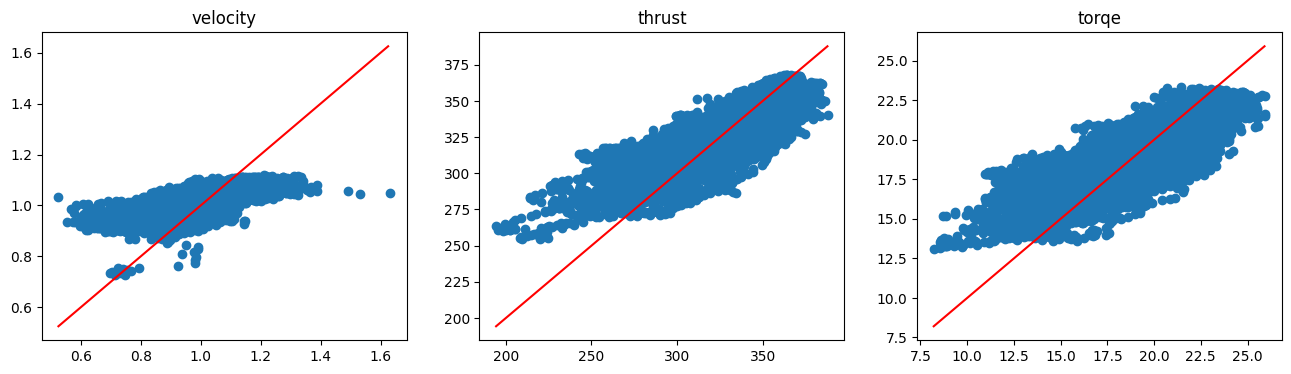

In [5]:
plot_reconstructed(means_preds, targets_means)

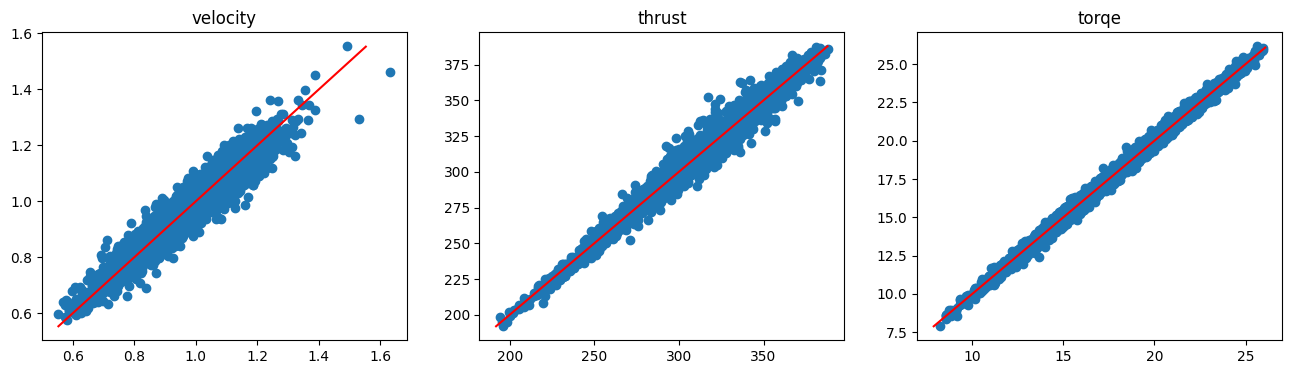

In [6]:
plot_reconstructed(firsts_preds, targets_firsts)

In [6]:
# pred
preds = average_predictions(predictions, batch_size, only_first=False)

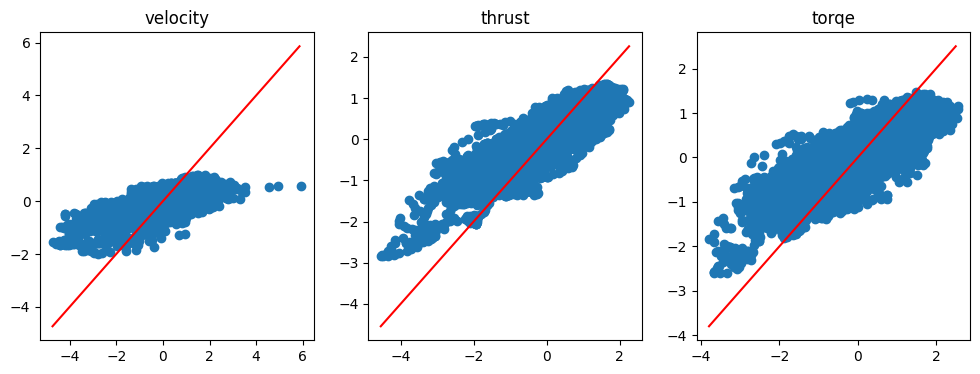

In [8]:
# targets
batch_y_list = []
for batch in test_loader:
    x,y = batch
    batch_y_list.append(y)
    
targets = average_predictions(batch_y_list, batch_size, only_first=True)

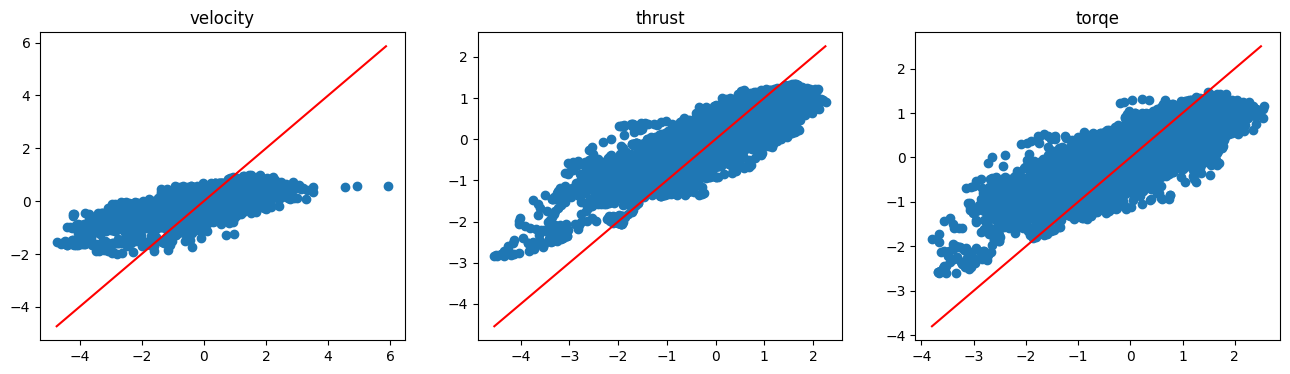

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16,4))
titles = ['velocity', 'thrust', 'torqe']
for i in range(3):
    min_val = min(np.min(targets[:,i]), np.min(preds[:,i]))
    max_val = max(np.max(targets[:,i]), np.max(preds[:,i]))

    axes[i].scatter(targets[:,i], preds[:,i])

    temp = np.arange(min_val,max_val,0.1)
    axes[i].plot(temp, temp, c='r')

    axes[i].title.set_text(titles[i])

plt.show()

In [16]:
x = [np.array([[1,2],[3,4]]), np.array([[5,6],[7,8]])]
x

[array([[1, 2],
        [3, 4]]),
 array([[5, 6],
        [7, 8]])]

In [17]:
np.mean(x, axis=0)

array([[3., 4.],
       [5., 6.]])

# covariates

In [2]:
# coding=utf-8
# Copyright 2023 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Directory to extract time covariates.

Extract time covariates from datetime.
"""

import numpy as np
import pandas as pd
from pandas.tseries.holiday import EasterMonday
from pandas.tseries.holiday import GoodFriday
from pandas.tseries.holiday import Holiday
from pandas.tseries.holiday import SU
from pandas.tseries.holiday import TH
from pandas.tseries.holiday import USColumbusDay
from pandas.tseries.holiday import USLaborDay
from pandas.tseries.holiday import USMartinLutherKingJr
from pandas.tseries.holiday import USMemorialDay
from pandas.tseries.holiday import USPresidentsDay
from pandas.tseries.holiday import USThanksgivingDay
from pandas.tseries.offsets import DateOffset
from pandas.tseries.offsets import Day
from pandas.tseries.offsets import Easter
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


# This is 183 to cover half a year (in both directions), also for leap years
# + 17 as Eastern can be between March, 22 - April, 25
MAX_WINDOW = 183 + 17


def _distance_to_holiday(holiday):
  """Return distance to given holiday."""

  def _distance_to_day(index):
    holiday_date = holiday.dates(
        index - pd.Timedelta(days=MAX_WINDOW),
        index + pd.Timedelta(days=MAX_WINDOW),
    )
    assert (
        len(holiday_date) != 0  # pylint: disable=g-explicit-length-test
    ), f"No closest holiday for the date index {index} found."
    # It sometimes returns two dates if it is exactly half a year after the
    # holiday. In this case, the smaller distance (182 days) is returned.
    return (index - holiday_date[0]).days

  return _distance_to_day


EasterSunday = Holiday(
    "Easter Sunday", month=1, day=1, offset=[Easter(), Day(0)]
)
NewYearsDay = Holiday("New Years Day", month=1, day=1)
SuperBowl = Holiday(
    "Superbowl", month=2, day=1, offset=DateOffset(weekday=SU(1))
)
MothersDay = Holiday(
    "Mothers Day", month=5, day=1, offset=DateOffset(weekday=SU(2))
)
IndependenceDay = Holiday("Independence Day", month=7, day=4)
ChristmasEve = Holiday("Christmas", month=12, day=24)
ChristmasDay = Holiday("Christmas", month=12, day=25)
NewYearsEve = Holiday("New Years Eve", month=12, day=31)
BlackFriday = Holiday(
    "Black Friday",
    month=11,
    day=1,
    offset=[pd.DateOffset(weekday=TH(4)), Day(1)],
)
CyberMonday = Holiday(
    "Cyber Monday",
    month=11,
    day=1,
    offset=[pd.DateOffset(weekday=TH(4)), Day(4)],
)

HOLIDAYS = [
    EasterMonday,
    GoodFriday,
    USColumbusDay,
    USLaborDay,
    USMartinLutherKingJr,
    USMemorialDay,
    USPresidentsDay,
    USThanksgivingDay,
    EasterSunday,
    NewYearsDay,
    SuperBowl,
    MothersDay,
    IndependenceDay,
    ChristmasEve,
    ChristmasDay,
    NewYearsEve,
    BlackFriday,
    CyberMonday,
]


class TimeCovariates(object):
  """Extract all time covariates except for holidays."""

  def __init__(
      self,
      datetimes,
      normalized = True,
      holiday = False,
  ):
    """Init function.

    Args:
      datetimes: pandas DatetimeIndex (lowest granularity supported is min)
      normalized: whether to normalize features or not
      holiday: fetch holiday features or not

    Returns:
      None
    """
    self.normalized = normalized
    self.dti = datetimes
    self.holiday = holiday

  def _minute_of_hour(self):
    minutes = np.array(self.dti.minute, dtype=np.float32)
    if self.normalized:
      minutes = minutes / 59.0 - 0.5
    return minutes

  def _hour_of_day(self):
    hours = np.array(self.dti.hour, dtype=np.float32)
    if self.normalized:
      hours = hours / 23.0 - 0.5
    return hours

  def _day_of_week(self):
    day_week = np.array(self.dti.dayofweek, dtype=np.float32)
    if self.normalized:
      day_week = day_week / 6.0 - 0.5
    return day_week

  def _day_of_month(self):
    day_month = np.array(self.dti.day, dtype=np.float32)
    if self.normalized:
      day_month = day_month / 30.0 - 0.5
    return day_month

  def _day_of_year(self):
    day_year = np.array(self.dti.dayofyear, dtype=np.float32)
    if self.normalized:
      day_year = day_year / 364.0 - 0.5
    return day_year

  def _month_of_year(self):
    month_year = np.array(self.dti.month, dtype=np.float32)
    if self.normalized:
      month_year = month_year / 11.0 - 0.5
    return month_year

  def _week_of_year(self):
    week_year = np.array(self.dti.strftime("%U").astype(int), dtype=np.float32)
    if self.normalized:
      week_year = week_year / 51.0 - 0.5
    return week_year

  def _get_holidays(self):
    dti_series = self.dti.to_series()
    hol_variates = np.vstack(
        [
            dti_series.apply(_distance_to_holiday(h)).values
            for h in tqdm(HOLIDAYS)
        ]
    )
    # hol_variates is (num_holiday, num_time_steps), the normalization should be
    # performed in the num_time_steps dimension.
    return StandardScaler().fit_transform(hol_variates.T).T

  def get_covariates(self):
    """Get all time covariates."""
    moh = self._minute_of_hour().reshape(1, -1)
    hod = self._hour_of_day().reshape(1, -1)
    dom = self._day_of_month().reshape(1, -1)
    dow = self._day_of_week().reshape(1, -1)
    doy = self._day_of_year().reshape(1, -1)
    moy = self._month_of_year().reshape(1, -1)
    woy = self._week_of_year().reshape(1, -1)

    all_covs = [
        moh,
        hod,
        dom,
        dow,
        doy,
        moy,
        woy,
    ]
    columns = ["moh", "hod", "dom", "dow", "doy", "moy", "woy"]
    if self.holiday:
      hol_covs = self._get_holidays()
      all_covs.append(hol_covs)
      columns += [f"hol_{i}" for i in range(len(HOLIDAYS))]

    return pd.DataFrame(
        data=np.vstack(all_covs).transpose(),
        columns=columns,
        index=self.dti,
    )


In [4]:
from datetime import datetime, timedelta

date_index = pd.date_range(datetime.now() - timedelta(days=5) , datetime.now())
date_index

DatetimeIndex(['2023-07-06 12:19:58.158603', '2023-07-07 12:19:58.158603',
               '2023-07-08 12:19:58.158603', '2023-07-09 12:19:58.158603',
               '2023-07-10 12:19:58.158603', '2023-07-11 12:19:58.158603'],
              dtype='datetime64[ns]', freq='D')

In [6]:
TimeCovariates(date_index).get_covariates()

,moh,hod,dom,dow,doy,moy,woy
2023-07-06 12:19:58.158603,-0.177966,0.021739,-0.300000,0.000000,0.013736,0.136364,0.029412
2023-07-07 12:19:58.158603,-0.177966,0.021739,-0.266667,0.166667,0.016484,0.136364,0.029412
2023-07-08 12:19:58.158603,-0.177966,0.021739,-0.233333,0.333333,0.019231,0.136364,0.029412
2023-07-09 12:19:58.158603,-0.177966,0.021739,-0.200000,0.500000,0.021978,0.136364,0.049020
2023-07-10 12:19:58.158603,-0.177966,0.021739,-0.166667,-0.500000,0.024725,0.136364,0.049020
2023-07-11 12:19:58.158603,-0.177966,0.021739,-0.133333,-0.333333,0.027473,0.136364,0.049020
